In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
from lie.SE23 import *
from flowpipe.inner_bound import *
from flowpipe.outer_bound import *
from flowpipe.flowpipe import *
from sim.multirotor_control import *
from sim.multirotor_plan import *

In [77]:
# solve LMI
sol = find_omega_invariant_set([0], [0], [0]) # solve LMI at hover

In [18]:
B, K, BK, A = omega_solve_control_gain(0, 0, 0) # solve control gain at hover
U,S,V = np.linalg.svd(BK)
sigma = max(S) # max singular value
print(sigma)
est_e = 3 # estimator error in deg
w = sigma*np.deg2rad(est_e) # singular value * bound from estimator

3.16227766016838


In [19]:
# Initial condition
P = sol['P']
e0 = np.array([0,0,0]) # initial error
beta = (e0.T@P@e0) # initial Lyapnov value

# find bound
omegabound = omega_bound([0], [0], [0], w, beta) # result for inner bound
print(omegabound)

0.052359877596339484


In [20]:
# map invariant set points to Lie group (nonlinear)
inv_points, val = omega_invariant_set_points(sol, 20, w, beta)

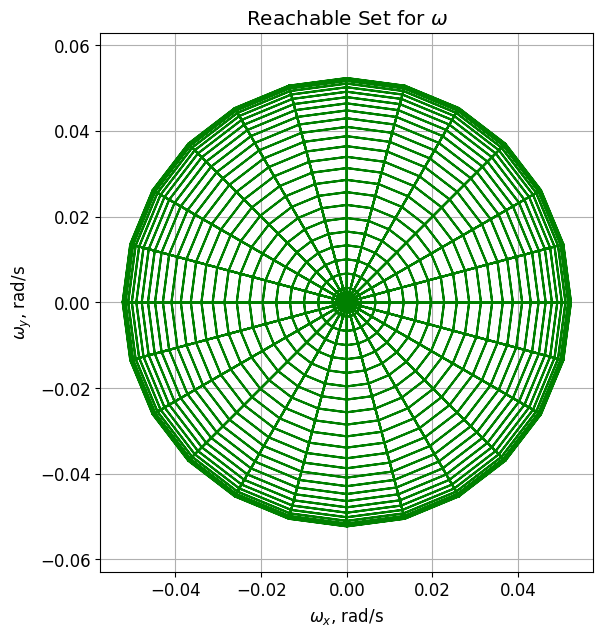

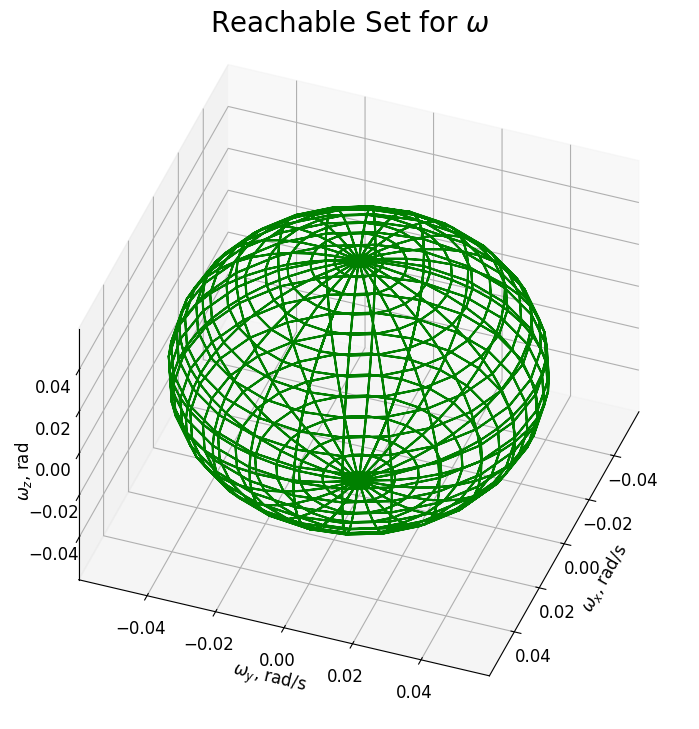

In [24]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 12})
ax1 = plt.subplot(121)
ax1.plot(inv_points[0, :], inv_points[1, :], 'g')
# ax.plot(pointscl[0, :], pointscl[1, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\omega_x$, rad/s')
ax1.set_ylabel('$\\omega_y$, rad/s')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
plt.title('Reachable Set for $\\omega$')


plt.figure(figsize=(14,7))
ax1 = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax1.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :],'g')
# ax.plot3D(pointscl[0, :], pointscl[1, :], pointscl[2, :],'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\omega_x$, rad/s')
ax1.set_ylabel('$\\omega_y$, rad/s')
ax1.set_zlabel('$\\omega_z$, rad')
ax1.set_title('Reachable Set for $\\omega$', fontsize=20)
# plt.subplots_adjust(left=9, right=10, top=0.5, bottom=0.08)
# plt.tight_layout()
plt.axis('auto')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [22]:
u_points = np.zeros((3,inv_points.shape[1]))
for i in range(inv_points.shape[1]):
    e = np.array([inv_points[0,i], inv_points[1,i], inv_points[2,i]])
    u_points[:,i] = B@K@e

Text(0.5, 0.92, 'Invariant Set of Control Inputs $\\dot{\\omega}$')

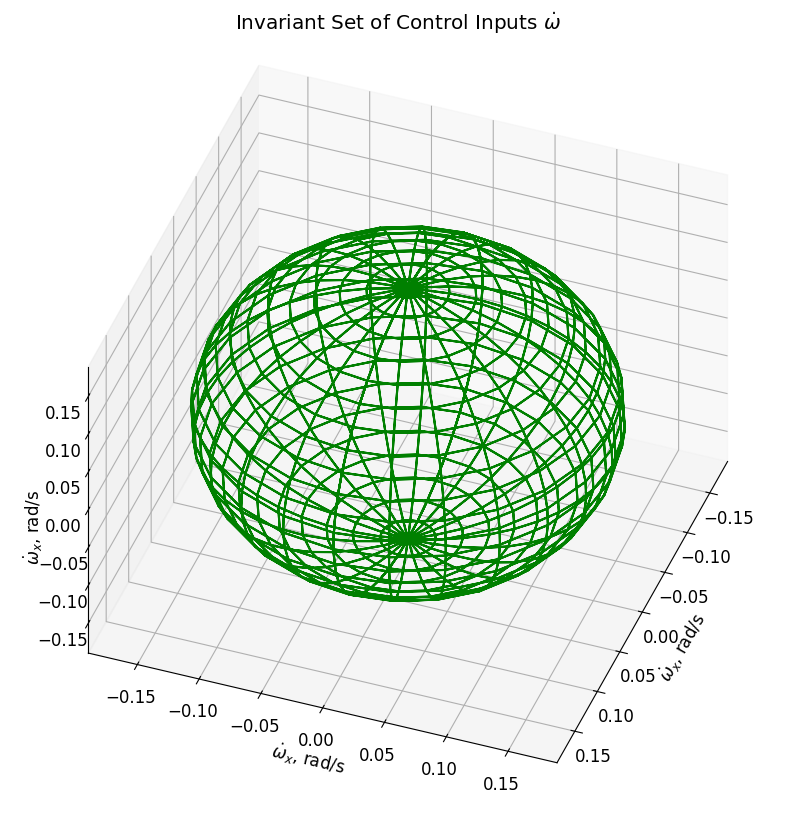

In [23]:
plt.figure(figsize=(10,12))
ax = plt.subplot(111, projection='3d', proj_type='ortho', elev=40, azim=20)
ax.plot3D(u_points[0, :], u_points[1, :], u_points[2, :],'g')
ax.set_xlabel('$\\dot{\\omega}_x$, rad/s')
ax.set_ylabel('$\\dot{\\omega}_x$, rad/s')
ax.set_zlabel('$\\dot{\\omega}_x$, rad/s')
ax.set_title('Invariant Set of Control Inputs $\\dot{\\omega}$')